# Word 2 Vec: A Quick Overview


## Motivation

For NLP, labeling data is a laborious, tedious, and error-prone task that requires a great amount of resources (e.g.  human hours). It would be nice to have unsupervised learning methods which learn the context of words and could classify them accordingly.

## Goal

Word2Vec tries to learn meaning and semantic relationships among words from large text corpora (that is, some kind of knowledge) in an unsupervised manner using the so-called Skip-gram model.

The results are analyzed in two ways:

* Given a context of words, find the appropriate word for that context
* Given a word, find the context that best suits that word


## Key Concepts

W2V learns a numerical embeddings space of a vocabluary which would result in similar words ending up close to each other. For example, in a vocabulary that includes countries and capitals, for the word "Spain", "Madrid" would be placed close it. The word "Paris" should appear a little bit further than "Madrid", and a totally unrelated word like for example "machine" even further. 

![See this example](embed_space.png)

When that numerical representation of the words in the vocabulary corpus is learnt, it enables to do vectorized operations. For example, we can do the operation `Spain - Madrid + France` should result in an embedded vector very close to `Paris`.

## Skip-grams

The goal of W2V's Skip-grams is train a model on the context of each word, so codifiying similar words in a manner that they will have similar numerical representations.

### Example

Training the model involves the followwing:
For a sentence like this: `Hillary climbed the Everest`, the model should learn that close to the word `Hillary`, it should appear the words `climbed` or `Everest`.

By repeating this with  multiple sentences with the adequate representation, the model learns a representation (i.e. Embedding) of the given input vocabulary. For example, if we add a new sentence `Norgay climbed the Everest` to the vocabulary and we train the model with representations `(input:Hillary,output:Everest)` and `(input:Norgay,output:Everest)`, eventually the model will "learn" that both, `Hillary` and `Norgay` are related to the word `Everest`, and will place them close together in the embedding space.

### Model Definition

Given a sequence of traning words $w_1,w_2,...w_T$ the goal is to *maximize the avg log probability*:

![Log Probability](log_prob.png)

where $c$ is the size of a training context (a function of the center word $w_t$). **The larger the context, the higher the accuracy**

In order to calculate $p(w_{t+j}|w_t)$ the **basic Skip-gram uses the Softmax fuction**:

![Softmax](softmax.png)

The model main features are: 

* Input Layer -> One hot encoding
* Hidden Layer -> Linear (identity)
* Output Layer -> Softmax

And it is shown in the next figure:

![Skip-gram Model](skip_gram.png)

where:

* V – Size of the vocabulary, or n umber of unique words in the input corpora
* P – Projection or the embedding layer
* D – Dimensionality of the embedding space (Basically the number of neurons in the hidden layer)
* b – Size of a single bach

![Word Embeddings](word_embeddings.png)

However, *in reality this is impractical because calculating the gradient of the log probability is proportional to the size of the vocabulary*, which is often **very large**. 

In order to solve this drawback, the W2V paper proposes two alternatives:

1. Hierarchical Softmax
2. Negative Sampling

### Hierarchical Softmax to the Rescue

An efficient way of computing the Softmax, using a binary tree to represent the vocabulary word, each word being a leaf of the tree. For each word, there's a unique path from the root that is used to estimate the probability of the word.
![Hierarchical Softmax](hsm.png)

In this model there's no output vector representation for words. Instead of this, each $V-1$ inner node has an output vector $v'_n(w,j)$. The probability of a word being the output is:

![Hierarchical Softmax Probability](hsm_prob.png)

where:

* $\sigma(x)$ is the sigmoid function
* $ch(n)$ is the left child of the node n
* $v'_n(w,j)$ is the output vector of the node $n(w,j)$
* $h$ is the output value of the hiddeln layer ($h=v_{wI}$)
* $[[x]]$ is a function defined as 1 if $x$ is true and -1 otherwise.

For example in order to calculate the probability that $w_2$ being the output word, and taking into account that the probabilities of going left and right are:

![Left prob](p_left.png) ![Right prob](p_right.png)

Followign the path from the root to $w_2$:

![W2 prob](p_root.png)

In order to represent the tree, W2V uses a binary Huffman tree because:

* It uses an efficient and short representation for frequent words
* Each inner node, always have both, left and right children 
* It's fast when training

**Using this model, the cost of computing $log p(w_O|w_I)$ and the gradient is proportional to the lenght of the path $L(w_O)$** and not to the size of the vocabulary as it happens when using the regular Softmax.

### Negative Sampling to the Rescue

As it has been mentioned above, there are two vectore representations  for each word in the vocabulary: the input vector $v_w$ and the output vector $v'_w$. Learning the input vectors is cheap *but compute the output vectors is very expensive*.

In order to cope with the difficulty of having too many output vectors -which need to be updated in each iteration- the negative sampling proposes to update *only* a sample of them.

The output word (or *positive sample*) should be kept in our sample and gets updates and we need to sample a few words as negative samples. In order to execute the sample process, a probabilistic distribution (a.k.a. *noise distribution*) is required. W2V uses a unigram distribution raised to the $3/4$th power. So, the goal is to distinguish the target word $w_O$ from draws of the noise distribution using logistic regression.

The authors say that the following simplified training objective is capable of producing high-quality word embeddings (Goldberg and Levy in 2014 provide a theoretical analysis on this):

![Negative Sampling Objective](neg_sampling.png)

where:

* $w_O$ is the output word
* $v'_{wO}$ is the output vector
* $h$ is the output value of the hiddeln layer ($h=v_{wI}$)
* $W_{neg}={w_j|j=1,...,K}$ is the set of words sampled based on the probabilistic function

This function is used to replace every $log P(w_O|w_I) in the Skip-gram objective function.

### Subsampling of Frequent Words

**Goal: accelerate the training process**

Skip-gram benefits from observing occurrences of "France" and "Paris", but benefits much less from co-occurrences of
"Paris" and "the", cause "the" is found close to nearly every word in the vocabulary.
To counter the imbalance between 'rare' and 'frequent' words, each word in the training set is discarded with the probability given by this formula:

![Subsampling Probability](subsampling_prob.png)

where:

* $f(w_i)$ is the frequency of word $w_i$
* $t$ is a chosen threshold which is $10^{-5}$ in the paper

## Results

Two categories in evaluation:

* Syntactic: "quick" : "quickly" :: "slow" should return "slowly"
* Semantic: "vec(Spain) - vec(Madrid) + vec(France)" should return "Paris" as we discussed above

![Result Comparison](result_comp.png)

### Evaluating Phrases

Move from words to phrases is managed in a relatively simple way:

1. Identify a large number of phrases using a data-driven approach based on unigram and bigram counting
2. Treat the phrases as individual tokens during training

![Phrase Comparison](phrase_comp.png)

![Phrase Accuracies](phrase_acc.png)

After this experiment, they used bigger datasets to demonstrate that having a large amount of data is critical. With a dimensionality of 1000 and the entire sentence for the context they achieved:

* 6 billion words -> 66% accuracy
* 33 billion words -> 72% accuracy

Infrequent phrases: Closest neighbors manually identified -> Hierarchical Softmax behaves better.
![Close Entities](close_entities.png)

### Additive Compositionality

*Idea behind this: Certain non-obvious degree of language understanding can be derived from the use of basic mathematical operations on the vector representations*

![Additive Compositionality](add_composability.png)


# TensorFlow Code

### Imports and Other Shit

In [23]:
from __future__ import print_function
import glob
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import urllib
import zipfile
from IPython.display import display
from ipywidgets import widgets
from matplotlib import pylab
from six.moves import range
from sklearn.manifold import TSNE

### Load Data

See [this website](http://mattmahoney.net/dc/) for more info on the data

In [24]:
zipped_data_filename = 'training_data.zip'

def download_data(from_url, target_filename):
    if os.path.exists(target_filename):
        print('File %s already exists' % target_filename)
    else:
        file = urllib.URLopener()
        file.retrieve(from_url, target_filename)
        print('File from url %s downloaded to %s' % (from_url, target_filename))

filename = download_data('http://mattmahoney.net/dc/text8.zip', zipped_data_filename)

File training_data.zip already exists


### Uncompress Data

In [25]:
def uncompress_datafile(filename, target_dir):
    with zipfile.ZipFile(filename) as zf:
        zf.extractall(target_dir)
        zf.close()
    print('Content in %s dir: %s' % (target_dir, glob.glob(target_dir + "/*")))

uncompress_datafile(zipped_data_filename, target_dir='.')

Content in . dir: ['./add_composability.png', './close_entities.png', './embed_space.png', './hsm.png', './hsm_prob.png', './log_prob.png', './neg_sampling.png', './p_left.png', './p_right.png', './p_root.png', './phrase_acc.png', './phrase_comp.png', './result_comp.png', './skip_gram.png', './softmax.png', './subsampling_prob.png', './text8', './training_data.zip', './Word2VecGuide.ipynb', './word_embeddings.png']


### Read Data as List of Words
It uses tensorflow compat lib to avoid incompatibilities in Strings in Python 2 (which uses bytes as internal representation) and 3 (which uses Unicode)

In [26]:
def read_data(filename):
    file = open(filename, 'r') 
    data = tf.compat.as_str(file.read()).split()
    file.close()
    return data
  
words = read_data('text8')

print('Numer of words in datafile: %d' % len(words))
print('First data elem is %s' % words[0])
print('Last data elem is %s' % words[-1])

Numer of words in datafile: 17005207
First data elem is anarchism
Last data elem is b


### Show First and Last Elements in List of Words

In [6]:
def f(lst):
    print(lst)

widgets.interact(f, lst=words[0:10])
widgets.interact(f, lst=words[-10:])

in


<function __main__.f>

### Dataset Construction

In [7]:
# Limit the size of the vocabulary
vocabulary_size = 50000

def build_dataset(words, limit):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(limit - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

input_data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)


The input data file starts like this:

"anarchism originated as a term of abuse first used against early working class radicals including the diggers of..."

In [8]:
print('Input data length (Words in file):', len(input_data))
print('Most common words (+UNK)', count[:13])
print('Least common words (+UNK)', count[-13:])
print('Pos of %s in dict: %d ' % ('UNK', dictionary['UNK']))
print('Pos of %s in dict: %d ' % ('the', dictionary['the']))
print('Word in pos %d of dict: %s' % (0, reverse_dictionary[0]))
print('Word in pos %d of dict: %s' % (1, reverse_dictionary[1]))
print('Word in pos %d of dict: %s' % (49999, reverse_dictionary[49999]))
print('First ten elements in sample data', input_data[:10])
for idx in input_data[:10]: print('Word in pos %d of dict: %s' % (idx, reverse_dictionary[idx]))

Input data length (Words in file): 17005207
Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430), ('two', 192644), ('is', 183153), ('as', 131815)]
Least common words (+UNK) [('caret', 9), ('abdicating', 9), ('aggadic', 9), ('amputee', 9), ('chordal', 9), ('cricketing', 9), ('impressively', 9), ('lith', 9), ('cropped', 9), ('mitsuda', 9), ('bundesland', 9), ('idm', 9), ('thien', 9)]
Pos of UNK in dict: 0 
Pos of the in dict: 1 
Word in pos 0 of dict: UNK
Word in pos 1 of dict: the
Word in pos 49999 of dict: thien
First ten elements in sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
Word in pos 5239 of dict: anarchism
Word in pos 3084 of dict: originated
Word in pos 12 of dict: as
Word in pos 6 of dict: a
Word in pos 195 of dict: term
Word in pos 2 of dict: of
Word in pos 3137 of dict: abuse
Word in pos 46 of dict: first
Word in pos 59 of 

In [9]:
# Global variable to keep track of the index of the data
data_index = 0

def generate_skip_gram_batch(batch_size, num_skips, skip_window):

    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span) # Circular buffer with the length of the span
    for _ in range(span):
        buffer.append(input_data[data_index])
        data_index = (data_index + 1) % len(input_data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(input_data[data_index])
        data_index = (data_index + 1) % len(input_data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(input_data) - span) % len(input_data)
    return batch, labels


### Example: "The dog barked at the mailman"

Initially, we pick a word from a text (dog), then we define a window called `skip_window` which is the number of words back and forth from the selected word we are going to look at. For example if skip_window = 2 then, `['The','dog','barked','at']` will be inside the window. 
Break the tuple `(input:'dog', output:['the','barked','at'])` to several single (input,output) tuples as:
1. `(input:'dog', output:'the')`,
2. `(input:'dog', output:'barked')`,
3. `(input:'dog', output:'at')`

We now define another parameter called `num_skips` denoting the number of different output words we will pick within the span for a single word. Now assuming `skip_window=2` and `num_skips=2` we would get the following (input,output) tuples:
1. `(input:'dog', output:'the')`,
2. `(input:'dog', output:'barked')`

# Hyperparameter Definition

Remember the input data file starts like this:

"anarchism originated as a term of abuse first used against early working class radicals including the diggers of..."

In [10]:
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

In [11]:
batch, labels = generate_skip_gram_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
print(labels.shape)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

# Reset data_index to not corrupt state when executing multiple executions of this code
data_index = 0

(8, 1)
3084 originated -> 5239 anarchism
3084 originated -> 12 as
12 as -> 3084 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


In [12]:
for skips, window in [(num_skips, skip_window), (4, 2)]:
    data_index = 0
    batch, labels = generate_skip_gram_batch(batch_size=8, num_skips=skips, skip_window=window)
    print('\nwith num_skips = %d and skip_window = %d:' % (skips, window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data_index = 0 # Reset data index after example


with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'originated', 'a', 'anarchism', 'originated', 'of', 'as', 'term']


In [13]:
# We pick a random validation set to sample nearest neighbors. The validation samples are limited to the words 
# that have a low numeric ID, which by construction of the input data set are also the most frequent.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.

# pick 16 samples from 100
valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
valid_examples = np.append(valid_examples,random.sample(range(1000,1000 + valid_window), valid_size // 2))
print(valid_examples)
num_sampled = 64 # Number of negative examples to sample.

num_steps = 30001
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.

[  92   64   63   71   96   75    6   53 1009 1086 1033 1001 1000 1048 1063
 1003]


# TF Placeholders for Input Data

In [14]:
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Variables

In [15]:
# embedding, vector for each word in the vocabulary
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# See this for truncated normal doc in TF: https://www.tensorflow.org/api_docs/python/tf/truncated_normal
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))

softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Model Definition

In [16]:
# Look up embeddings for inputs. This might efficiently find the embeddings for given ids (traind dataset)
# Manually doing this might not be efficient given there are 50000 entries in embeddings

embed = tf.nn.embedding_lookup(embeddings, train_dataset)
print("Embed size: %s"%embed.get_shape().as_list())

# Compute the softmax loss, using a sample of the negative labels each time.
# inputs are embeddings of the train words
# with this loss we optimize weights, biases, embeddings
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

Embed size: [128, 128]


# Optimizer

Note: The optimizer will optimize:

1. The softmax weights
2. The softmax biases
3. AND the embeddings


This is because the embeddings are defined as a variable quantity and the
optimizer's `minimize` method will by default modify all variable quantities
that contribute to the tensor it is passed.

See docs on `tf.train.Optimizer.minimize()` for more details.
Adagrad is required because there are too many things to optimize

In [17]:
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

# Compute Cosine Similarity Between Minibatch Examples and Embeddings


In [18]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [20]:
#print(norm.eval(session=sess))
print(valid_embeddings.shape)
print(normalized_embeddings.shape)
print(similarity.shape)

(16, 128)
(50000, 128)
(16, 50000)


# Main Execution Code

### Create Session

In [21]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('Session Initialized')

Session Initialized


### Loop

In [22]:
average_loss = 0

for step in range(num_steps):
    
    batch_data, batch_labels = generate_skip_gram_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
    _, l = sess.run([optimizer, loss], feed_dict=feed_dict)
    
    average_loss += l
    if step % 2000 == 0:
        if step > 0:
            average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
        print('Average loss at step %d: %f' % (step, average_loss))
        average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
        sim = similarity.eval(session=sess)
        for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log = '%s %s,' % (log, close_word)
            print(log)

final_embeddings = normalized_embeddings.eval(session=sess)

Average loss at step 0: 8.163368
Nearest to system: feedstock, grand, carson, mcc, esquerra, convicts, masurian, unit,
Nearest to american: unwise, failure, omphale, beli, vc, forebears, giroux, lejeune,
Nearest to into: magnitude, celebrate, garuda, tamias, orchids, boeing, azathoth, ambitions,
Nearest to world: grouping, ulvaeus, guyana, rough, strikeouts, refuses, neues, connexion,
Nearest to history: sequels, commitment, nepal, convection, targets, unheard, stamford, illustrations,
Nearest to d: doubt, fashions, hellespont, misspelling, stresses, bank, theatre, serve,
Nearest to a: recurrent, domains, insurers, spectators, optimistic, normed, attributed, attractors,
Nearest to can: ingolstadt, manichaean, cardinality, linen, destitute, tacitus, hatches, cleopatra,
Nearest to universe: anc, creatures, codeine, etonians, leakey, cleaved, flattened, tsim,
Nearest to arts: raskin, paternalistic, cushing, sarcophagus, fingerspelling, biya, words, involuntary,
Nearest to recorded: double

In [27]:
print(final_embeddings.shape)
final_embeddings


(50000, 128)


array([[ 0.12460083, -0.00079406,  0.02109937, ...,  0.21949464,
         0.06365179, -0.15148073],
       [-0.00054024,  0.05230185, -0.04494205, ..., -0.07891749,
         0.09985147, -0.0456957 ],
       [-0.00108435, -0.07800606, -0.02563362, ...,  0.03838554,
         0.04118828,  0.00314289],
       ..., 
       [-0.09073071,  0.1039853 ,  0.09633401, ...,  0.06608576,
        -0.13959458, -0.03595871],
       [-0.00627898,  0.02845284,  0.12039696, ..., -0.10853225,
        -0.08246864, -0.05663906],
       [ 0.15444215,  0.03110352,  0.00966335, ..., -0.00740812,
         0.03800033,  0.14456977]], dtype=float32)

### Visualization

In [28]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

0 X 20.0629841541, Y -31.30647635 Label: the
1 X 24.6775867937, Y 19.3069431052 Label: of
2 X 26.7509379027, Y 21.892743563 Label: and
3 X -19.1919839571, Y 28.4106110318 Label: one
4 X 23.0564758698, Y 33.7090762586 Label: in
5 X 21.7624139819, Y -26.2550721053 Label: a
6 X 50.6398265408, Y 12.2607471133 Label: to
7 X -26.7370766758, Y 25.6395320264 Label: zero
8 X -24.4919882849, Y 35.1733959391 Label: nine
9 X -23.4492916502, Y 31.6672002966 Label: two
10 X 32.7024919731, Y 5.53702653006 Label: is
11 X 23.0834971445, Y 21.626847225 Label: as
12 X -26.0450179988, Y 31.2764970098 Label: eight
13 X 26.121311255, Y 18.2990014035 Label: for
14 X -8.69350699735, Y 21.7752379899 Label: s
15 X -18.3581108558, Y 40.1517534823 Label: five
16 X -22.5869805933, Y 28.434304907 Label: three
17 X 32.1595790851, Y 3.83379212548 Label: was
18 X 18.9144138194, Y 12.7905334821 Label: by
19 X 38.9451823203, Y -24.645122483 Label: that
20 X -28.3602853368, Y 26.7637251756 Label: four
21 X -22.523572397,

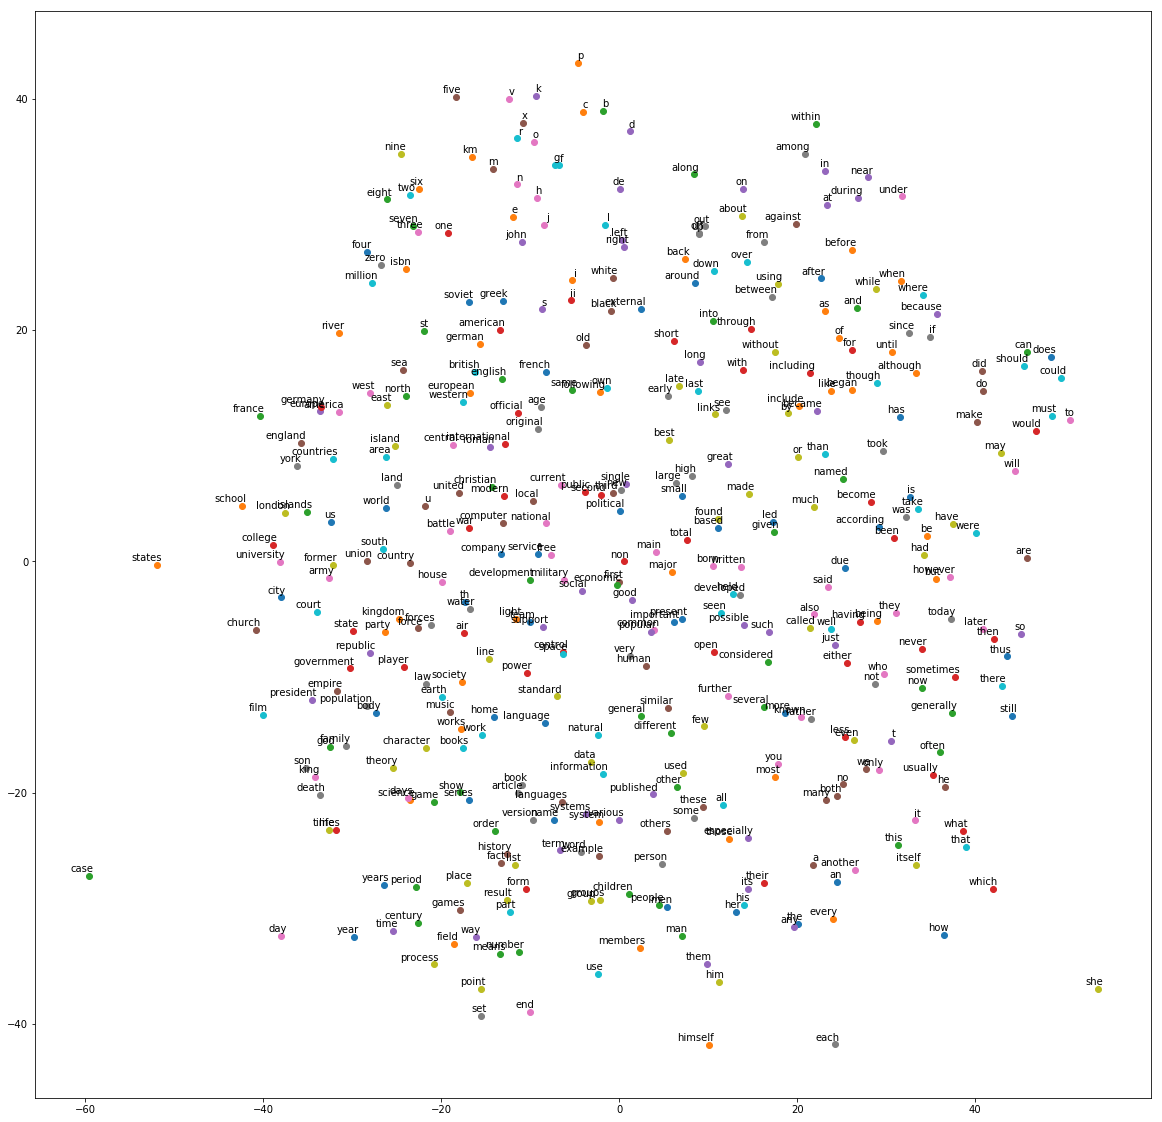

In [29]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(20,20))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        print("%d X %s, Y %s Label: %s" % (i, x, y, label))
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

# Basic References
1. [Word2Vec Paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
2. [Word2Vec Explained](https://arxiv.org/pdf/1411.2738.pdf)
3. [Skip-gram Implementation Description](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram)
4. [CBOW Implementation Description](http://www.thushv.com/natural_language_processing/word2vec-part-2-nlp-with-deep-learning-with-tensorflow-cbow/)